In [1]:
import pandas as pd
from pysd.translators.vensim.vensim_file import VensimFile
from stanify.builders.stan.stan_model import StanVensimModel
import numpy as np
import cmdstanpy
import matplotlib.pyplot as plt
%matplotlib inline 
import random
import arviz as az

## 1. data2draws: generate and prior predictive check

1. Define Data template
2. Define Joint distribution p(theta, y)
3. Define Approximator

In [22]:
random.seed(100)

obs_stock_df = pd.read_csv('data/hudson-bay-lynx-hare.csv')
vf = VensimFile("vensim_models/prey-predator/prey-predator.mdl")
vf.parse()
am = vf.get_abstract_model()

# 1. D
n_t = obs_stock_df.shape[0] - 1
data_draws2data = {
    "n_t": n_t,
    "predator_obs":  obs_stock_df.loc[1:, 'Predator'].values.tolist(),
    "prey_obs": obs_stock_df.loc[1:, 'Prey'].values.tolist(),
}

# 2. P
model = StanVensimModel("prey-predator", am, 0.0, list(range(1, n_t + 1)), data_dict = data_draws2data)

## a. set_prior_var
### 1) ode parameter prior
model.set_prior("alpha", "normal", 0.8, 0.1)
model.set_prior("beta", "normal", 0.05, 0.001)
model.set_prior("delta", "normal", 0.05, 0.001)
model.set_prior("gamma", "normal", 0.8, 0.1)

# experiment with different values
# model.set_prior("alpha", "normal", 0.55, 0.1)
# model.set_prior("beta", "normal", 0.028, 0.001)
# model.set_prior("delta", "normal", 0.024, 0.001)
# model.set_prior("gamma", "normal", 0.8, 0.1)

### 2) sampling distribution parameter (measruement error) prior
model.set_prior("sigma", "lognormal", np.log(0.001), 0.001)

### 3)  measurement \tilde{y}_{1..t} ~ f(\theta, t)_{1..t}
model.set_prior("predator_obs", "lognormal", "predator", "sigma")
model.set_prior("prey_obs", "lognormal", "prey", "sigma")

## b. set_prior_struc
model.build_stan_functions()

## c. set_prior_demand #TODO

## a + b + c
model.stanify_draws2data()

# 1+2. P(D)
draws2data_model = cmdstanpy.CmdStanModel(stan_file="stan_files/prey-predator_draws2data.stan")

# 3. A(P(D))
prior_pred = draws2data_model.sample(data=data_draws2data, fixed_param=True)

prey-predator_functions.stan already exists in the current working directory. Overwrite? (Y/N):y


19:36:59 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data.stan to exe file /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data


['alpha', 'beta', 'delta', 'gamma', 'sigma', 'predator_obs', 'prey_obs']


19:37:04 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data
19:37:04 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
19:37:04 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files --o=/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data.hpp /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_draws2data.stan', line 29, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ co

chain 1 |          | 00:00 Status

19:37:05 - cmdstanpy - INFO - CmdStan done processing.


## Compare prior predictions with real data

Table shows the sampled prior values and the generated stock variables (target simulated measured).

In [23]:
prior_pred.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,8.007130e-01,3.015580e-03,1.015970e-01,0.634381,8.013080e-01,9.701210e-01,1135.050,6037.52,0.999037
beta,5.003440e-02,3.600690e-05,1.005720e-03,0.048360,5.005870e-02,5.168280e-02,780.159,4149.78,0.999358
delta,5.003150e-02,3.309850e-05,9.968640e-04,0.048362,5.006130e-02,5.166600e-02,907.100,4825.00,0.999081
gamma,8.007640e-01,3.235840e-03,1.033300e-01,0.637672,8.008460e-01,9.680380e-01,1019.710,5423.96,1.002980
sigma,9.999980e-04,3.103050e-08,9.826520e-07,0.000998,9.999960e-04,1.001660e-03,1002.810,5334.12,0.999089
...,...,...,...,...,...,...,...,...,...
prey_obs[16],2.523556e+23,1.427397e+23,4.532478e+24,5.890150,2.391560e+03,4.237560e+15,1008.280,5363.20,0.999747
prey_obs[17],7.584205e+22,3.809929e+22,1.210792e+24,9.588300,1.336750e+06,4.774900e+20,1009.960,5372.14,1.000200
prey_obs[18],2.511688e+22,8.106517e+21,2.589852e+23,30.066700,7.341840e+09,6.552710e+21,1020.660,5429.05,0.999684
prey_obs[19],4.809385e+21,2.680713e+21,8.512878e+22,56.774300,1.479390e+11,9.269910e+20,1008.450,5364.07,1.001120


We select the five prior draws and compare the prior predictive values with real data.

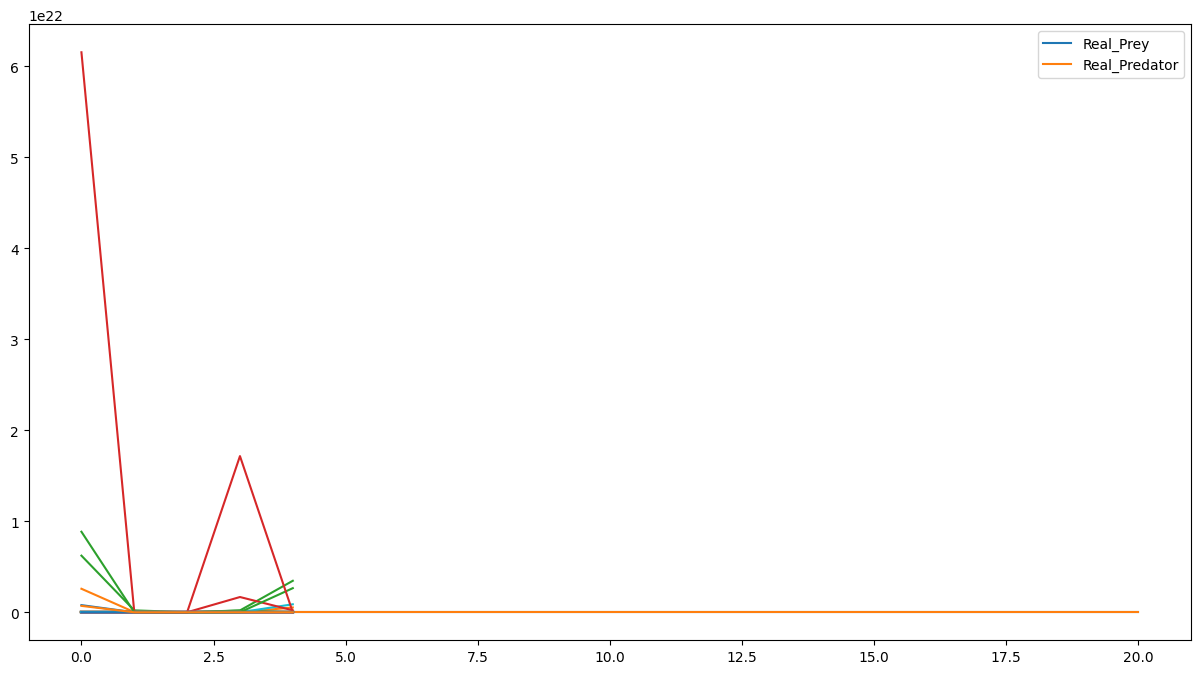

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(obs_stock_df.loc[:, ['Prey']], label = "Real_Prey")
ax.plot(obs_stock_df.loc[:, ['Predator']], label = "Real_Predator")
ax.plot(pd.DataFrame(prior_pred.draws_xr('prey_obs').squeeze("chain").prey_obs[:5,:]))
ax.plot(pd.DataFrame(prior_pred.draws_xr('predator_obs').squeeze("chain").predator_obs[:5,:]))
ax.legend()

Even though we have used the parameter value from the literature, it is hard to get prior value that generate observed data.

## 2. data2draws: estimation and posterior predictive check

In [28]:
random.seed(100)

# ORDER is important
# 1. D
n_t = obs_stock_df.shape[0] - 1
data_data2draws = {
    "n_obs_state" : 2,
    "n_t": n_t,
    "predator_obs":  obs_stock_df.loc[1:, 'Predator'].values.tolist(),
    "prey_obs": obs_stock_df.loc[1:, 'Prey'].values.tolist(),
}

# 2. P
model = StanVensimModel("prey-predator", am, 0.0, list(range(1, n_t + 1)), data_dict=data_data2draws)

## a. set_prior_var

### 1) ode parameter prior
model.set_prior("alpha", "normal", 0.8, 0.1)
model.set_prior("beta", "normal", 0.05, 0.001)
model.set_prior("delta", "normal", 0.05, 0.001)
model.set_prior("gamma", "normal", 0.8, 0.1)

### 2) sampling distribution parameter (measruement error) prior
model.set_prior("sigma", "lognormal", np.log(0.01), 0.1)

### 3)  measurement \tilde{y}_{1..t} ~ f(\theta, t)_{1..t}
model.set_prior("predator_obs", "lognormal", "predator", "sigma")
model.set_prior("prey_obs", "lognormal", "prey", "sigma")

## b. set_prior_struc
model.build_stan_functions()  

## c. set_prior_demand #TODO

## a + b + c
model.stanify_data2draws()

# 1+2. P(D)
data2draws_model = cmdstanpy.CmdStanModel(stan_file="stan_files/prey-predator_data2draws.stan")

# 3. A(P(D))
posterior = data2draws_model.sample(data=data_data2draws)

prey-predator_functions.stan already exists in the current working directory. Overwrite? (Y/N):y


19:37:35 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan to exe file /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws
19:37:42 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws
19:37:42 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
19:37:42 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files --o=/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.hpp /Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan
Warning in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan', line 34, column 4: Declaration
    of array

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:40:31 - cmdstanpy - INFO - CmdStan done processing.
19:40:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -0.0189927, but must be nonnegative! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan', line 44, column 4 to column 47)
	Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan', line 45, column 4 to column 46)
	Exception: ode_rk45:  Failed to integrate to next output time (10) in less than max_num_steps steps (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan', line 34, column 4 to column 130)
	Exception: ode_rk45:  Failed to integrate to next output time (13) in less than max_num_steps steps (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws.stan',

Without lower bound of parameters (as zero), estimated result can be negative, e.g. alpha from the following table.

In [32]:
posterior.summary().loc[('alpha', 'beta', 'delta', 'gamma'),]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,-0.501516,0.001117,0.045904,-0.577483,-0.501387,-0.425863,1689.09,150.369,0.999997
beta,0.050807,0.000015,0.001036,0.049101,0.050822,0.052500,4566.26,406.504,1.000920
delta,0.049834,0.000014,0.001006,0.048186,0.049834,0.051480,5092.48,453.350,0.999600
gamma,0.690632,0.001279,0.066815,0.580250,0.689815,0.800841,2729.97,243.031,1.000430


## loglikelihood and plot posterior predictive

 Remedy: edit stanfile. We will add three components manually: bounds, log likelihood, posterior predictive values. 

0. Go to stanfile folder, find file ending with '_data2draws.stan' 
1. add <lower = 0> to parameters in `parameters` block
2. add `generated quantities` block in the end, declare `loglik` and `stock_tilde` you wish to generate with estimated parameter values

In [34]:
random.seed(100)
# 1+2. P(D)
data2draws_model_full = cmdstanpy.CmdStanModel(stan_file="stan_files/prey-predator_data2draws_full.stan")

# 3. A(P(D))
posterior_full = data2draws_model_full.sample(data=data_data2draws)

19:41:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:44:23 - cmdstanpy - INFO - CmdStan done processing.
19:44:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws_full.stan', line 45, column 4 to column 46)
	Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws_full.stan', line 45, column 4 to column 46)
	Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws_full.stan', line 45, column 4 to column 46)
	Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/Dropbox/BayesSD/ContinuousCode/explore/stan_files/prey-predator_data2draws_full.stan', line 45, column 4 to column 46)


19:44:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 3 had 1 iterations at max treedepth (0.1%)
	Use function "diagnose()" to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,0.101465,0.736660,1.043940,-0.570700,-0.480258,1.908170,2.00824,0.139859,28.35380
beta,0.295267,0.299004,0.423631,0.049357,0.051258,1.043160,2.00735,0.139797,54.00640
delta,0.027669,0.027104,0.038407,-0.039973,0.049391,0.051389,2.00788,0.139834,36.81500
gamma,0.483299,0.252355,0.361095,-0.134067,0.658294,0.791757,2.04748,0.142592,6.65533


In [43]:
posterior_full.summary().loc[('alpha', 'beta', 'delta', 'gamma'),]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,0.101465,0.736660,1.043940,-0.570700,-0.480258,1.908170,2.00824,0.139859,28.35380
beta,0.295267,0.299004,0.423631,0.049357,0.051258,1.043160,2.00735,0.139797,54.00640
delta,0.027669,0.027104,0.038407,-0.039973,0.049391,0.051389,2.00788,0.139834,36.81500
gamma,0.483299,0.252355,0.361095,-0.134067,0.658294,0.791757,2.04748,0.142592,6.65533


Giving bounds not only makes assures reasonable estimates but also shortens computation time in most cases. Total sampling time for `data2draws_model_full` is 2:30 min while `data2draws_model` (without bound) is 2:48 min; the gap may increase with larger number of estimated parameters.

array([<AxesSubplot: xlabel='prey / prey'>,
       <AxesSubplot: xlabel='predator / predator'>], dtype=object)

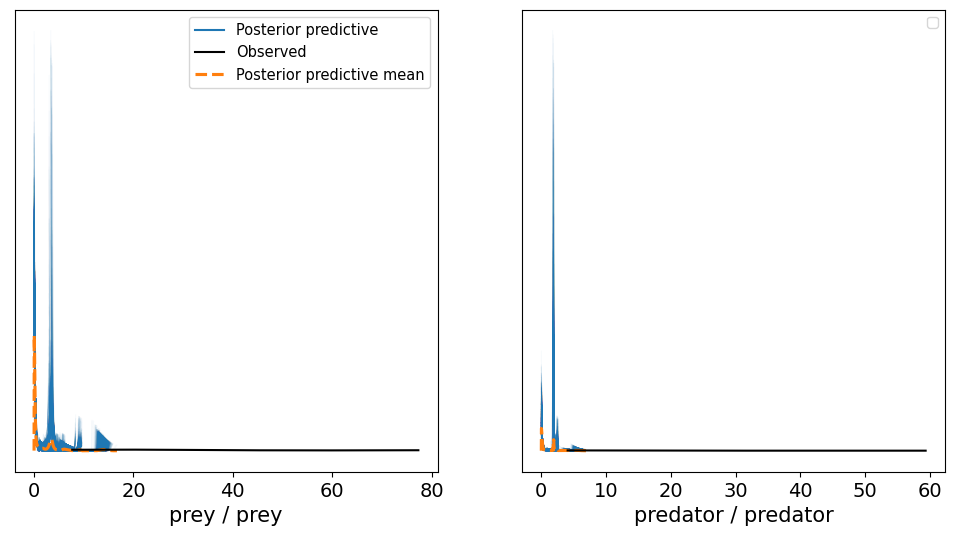

In [49]:
idata = az.from_cmdstanpy(
    posterior=posterior_full, 
    posterior_predictive=["predator","prey"], 
    log_likelihood= ["log_lik"],
    observed_data = {"prey": obs_stock_df.loc[:, ("Prey")], "predator": obs_stock_df.loc[:, ("Predator")]}
)
az.plot_ppc(idata, alpha=0.03, figsize=(12, 6))

For some reason, Stan gives a warning (based on loglikelihood) that the fit is very bad.

In [50]:
az.loo(idata)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo      nan      nan
p_loo         nan        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1  100.0%

## TODO 3. draws2data2draws: simulation-based calibration

## Stan code

In [35]:
print(draws2data_model.code())
print(data2draws_model_full.code())

functions{
#include prey-predator_functions.stan
}
data{
    int n_t;
}

transformed data{
    real initial_time = 0.0;
    array[n_t] real times = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20};
}


generated quantities{
    real alpha = normal_rng(0.8, 0.1);
    real beta = normal_rng(0.05, 0.001);
    real delta = normal_rng(0.05, 0.001);
    real gamma = normal_rng(0.8, 0.1);
    real sigma = lognormal_rng(-6.907755278982137, 0.001);

    // Initial ODE values
    real prey__init = 30;
    real predator__init = 4;

    vector[2] initial_outcome;  // Initial ODE state vector
    initial_outcome[1] = prey__init;
    initial_outcome[2] = predator__init;

    vector[2] integrated_result[n_t] = ode_rk45(vensim_ode_func, initial_outcome, initial_time, times, delta, beta, alpha, gamma);
    array[n_t] real prey = integrated_result[:, 1];
    array[n_t] real predator = integrated_result[:, 2];

    vector[20] predator_obs = to_vector(lognormal_rng(predator, sigma))